#  LOADING THE DATASET 

In [6]:
import pandas as pd

file_path = "complaints.csv"

# Load full dataset
df = pd.read_csv(file_path, low_memory=False)

print(df.shape)   # total rows & columns
print(df.head())  # preview


(105643, 18)
  Date received                                            Product  \
0    2020-07-06  Credit reporting, credit repair services, or o...   
1    2025-09-29  Credit reporting or other personal consumer re...   
2    2023-08-09  Credit reporting, credit repair services, or o...   
3    2025-09-28  Credit reporting or other personal consumer re...   
4    2025-09-29  Credit reporting or other personal consumer re...   

        Sub-product                                 Issue  \
0  Credit reporting  Incorrect information on your report   
1  Credit reporting  Incorrect information on your report   
2  Credit reporting  Incorrect information on your report   
3  Credit reporting  Incorrect information on your report   
4  Credit reporting           Improper use of your report   

                                       Sub-issue Consumer complaint narrative  \
0            Information belongs to someone else                          NaN   
1                  Account informatio

#   CHECKING COLUMNS

In [7]:
print(df.columns.tolist())


['Date received', 'Product', 'Sub-product', 'Issue', 'Sub-issue', 'Consumer complaint narrative', 'Company public response', 'Company', 'State', 'ZIP code', 'Tags', 'Consumer consent provided?', 'Submitted via', 'Date sent to company', 'Company response to consumer', 'Timely response?', 'Consumer disputed?', 'Complaint ID']


#  CHECKING MISSING TEXT

In [8]:
print(df["Consumer complaint narrative"].isnull().sum())
print(df["Consumer complaint narrative"].notnull().sum())


72715
32928


#  KEEPING ONLY TEXT ROWS

In [9]:
df = df.dropna(subset=["Consumer complaint narrative"])
df.rename(columns={"Consumer complaint narrative": "complaint"}, inplace=True)

print(df.shape)   # how many rows left after filtering
print(df["complaint"].head())


(32928, 18)
7      In XXXX, unauthorized transactions were made o...
67                            These are not my accounts.
130    Kindly address this issue on my credit report....
158    I want to stress that I did not give written p...
239    There are XXXX collections being reported to t...
Name: complaint, dtype: object


# SAVING SMALLER COPY A SMALLER DATASET

In [10]:
df.to_csv("complaints_text_only.csv", index=False)


# DATA PREPROCESSING

In [12]:
import re
import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")

stop_words = set(stopwords.words("english"))

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", "", text)   # remove links
    text = re.sub(r"[^a-z\s]", "", text)         # keep only letters
    text = " ".join([w for w in text.split() if w not in stop_words])
    return text

df["clean_complaint"] = df["complaint"].apply(clean_text)
print(df[["complaint","clean_complaint"]].head())

[nltk_data] Downloading package stopwords to C:\Users\Ananya
[nltk_data]     Goel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                                             complaint  \
7    In XXXX, unauthorized transactions were made o...   
67                          These are not my accounts.   
130  Kindly address this issue on my credit report....   
158  I want to stress that I did not give written p...   
239  There are XXXX collections being reported to t...   

                                       clean_complaint  
7    xxxx unauthorized transactions made cash app a...  
67                                            accounts  
130  kindly address issue credit report assert acco...  
158  want stress give written permission specific t...  
239  xxxx collections reported consumer agencies lo...  


In [13]:
# Remove xxxx or similar redacted tokens
df["clean_complaint"] = df["clean_complaint"].str.replace(r"x+", "", regex=True)

# Double check
print(df["clean_complaint"].head())


7       unauthorized transactions made cash app accou...
67                                              accounts
130    kindly address issue credit report assert acco...
158    want stress give written permission specific t...
239     collections reported consumer agencies lockha...
Name: clean_complaint, dtype: object


# POS TAGGING AND NAMED ENTITY RECOGNITION

In [14]:
!pip install spacy


In [15]:
!python -m spacy download en_core_web_sm

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---- ----------------------------------- 1.6/12.8 MB 9.4 MB/s eta 0:00:02
     ---------- ----------------------------- 3.4/12.8 MB 8.8 MB/s eta 0:00:02
     ----------------- ---------------------- 5.5/12.8 MB 9.1 MB/s eta 0:00:01
     ------------------------- -------------- 8.1/12.8 MB 9.7 MB/s eta 0:00:01
     ----------------------------- ---------- 9.4/12.8 MB 9.0 MB/s eta 0:00:01
     ------------------------------------ --- 11.5/12.8 MB 9.1 MB/s eta 0:00:01
     ---------------------------------------- 12.8/12.8 MB 8.5 MB/s  0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [14]:
import spacy

# Load spaCy small English model
nlp = spacy.load("en_core_web_sm")

# Take a sample complaint to analyze
sample_text = df["clean_complaint"].iloc[0]
doc = nlp(sample_text)

# POS tagging
print("POS Tags:")
for token in doc:
    print(f"{token.text} → {token.pos_}")

# Named Entity Recognition
print("\nNamed Entities:")
for ent in doc.ents:
    print(f"{ent.text} → {ent.label_}")


POS Tags:
  → SPACE
unauthorized → ADJ
transactions → NOUN
made → VERB
cash → NOUN
app → NOUN
account → NOUN
without → ADP
knowledge → NOUN
consent → NOUN
later → ADV
received → VERB
irs → PROPN
notice → NOUN
large → ADJ
ta → ADP
liability → NOUN
connected → VERB
activity → NOUN
account → NOUN
authorize → NOUN
recognize → VERB
despite → SCONJ
multiple → ADJ
attempts → NOUN
contact → NOUN
cash → NOUN
app → NOUN
support → NOUN
official → ADJ
channels → NOUN
received → VERB
assistance → NOUN
resolution → NOUN
requesting → VERB
investigation → NOUN
fraudulent → NOUN
transactions → NOUN
verification → NOUN
income → NOUN
reported → VERB
ta → ADP
authorities → NOUN
name → VERB
immediate → ADJ
action → NOUN
secure → ADJ
account → NOUN
prevent → VERB
unauthorized → ADJ
activity → NOUN

Named Entities:
irs → ORG


# PARSING

In [17]:
import spacy

# Load English parser
nlp = spacy.load("en_core_web_sm")

# Example: parse one complaint
text = df["clean_complaint"].iloc[7]  # take one cleaned complaint
doc = nlp(text)

print("Dependency Parsing:")
for token in doc:
    print(f"{token.text:15} {token.dep_:10} {token.head.text:15} {token.head.pos_:10} {token.pos_}")


Dependency Parsing:
want            advcl      authorize       VERB       VERB
stress          nsubj      give            VERB       NOUN
give            ccomp      want            VERB       VERB
written         amod       transactions    NOUN       VERB
permission      compound   transactions    NOUN       NOUN
specific        amod       transactions    NOUN       ADJ
transactions    dobj       give            VERB       NOUN
included        conj       want            VERB       VERB
consumer        compound   report          NOUN       NOUN
report          compound   point           NOUN       NOUN
point           dobj       included        VERB       NOUN
authorize       conj       want            VERB       VERB
entries         compound   presence        NOUN       NOUN
presence        compound   report          NOUN       NOUN
report          dobj       authorize       VERB       NOUN
unwarranted     amod       report          NOUN       ADJ
consequently    advmod     requesting 

# TREE VISUALISATION

In [15]:
from spacy import displacy

# Render dependency tree for first complaint
displacy.render(doc, style="dep", jupyter=True)


# SENTIMENT ANALYSIS

In [20]:
%pip install textblob

  Using cached textblob-0.19.0-py3-none-any.whl.metadata (4.4 kB)
Using cached textblob-0.19.0-py3-none-any.whl (624 kB)
Note: you may need to restart the kernel to use updated packages.


In [21]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package punkt to C:\Users\Ananya
[nltk_data]     Goel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Ananya Goel\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.


True

In [22]:
from textblob import TextBlob


In [16]:
from textblob import TextBlob

# Function to get sentiment polarity
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

# Apply to your dataset
df["sentiment"] = df["clean_complaint"].apply(get_sentiment)

# Check first few results
print(df[["complaint", "clean_complaint", "sentiment"]].head())

# Distribution of sentiment
print(df["sentiment"].describe())


                                             complaint  \
7    In XXXX, unauthorized transactions were made o...   
67                          These are not my accounts.   
130  Kindly address this issue on my credit report....   
158  I want to stress that I did not give written p...   
239  There are XXXX collections being reported to t...   

                                       clean_complaint  sentiment  
7     unauthorized transactions made cash app accou...   0.142857  
67                                            accounts   0.000000  
130  kindly address issue credit report assert acco...   0.425000  
158  want stress give written permission specific t...   0.055000  
239   collections reported consumer agencies lockha...   0.093750  
count    32928.000000
mean         0.032119
std          0.164626
min         -1.000000
25%         -0.060833
50%          0.010901
75%          0.121429
max          1.000000
Name: sentiment, dtype: float64


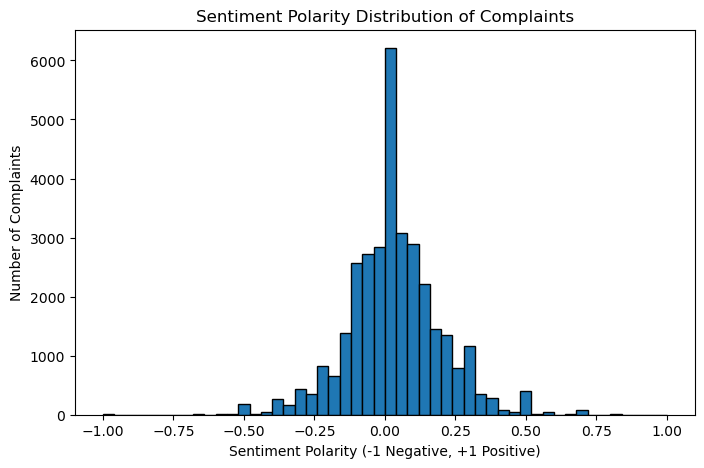

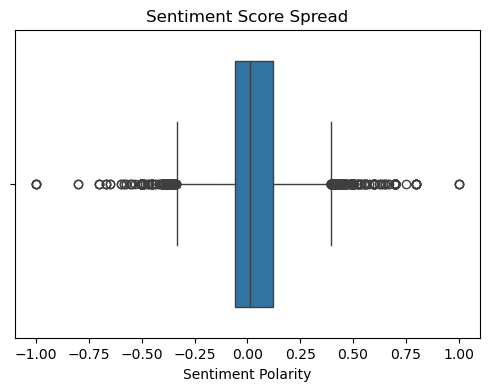

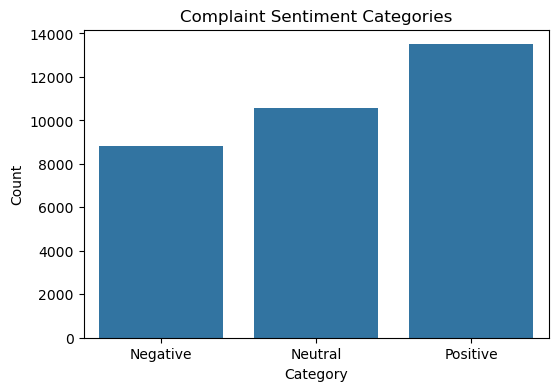

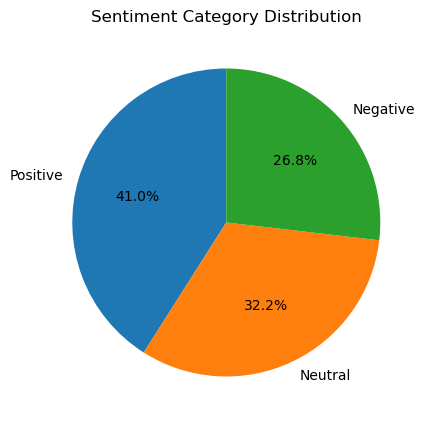

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histogram of sentiment polarity
plt.figure(figsize=(8,5))
plt.hist(df["sentiment"], bins=50, edgecolor="black")
plt.title("Sentiment Polarity Distribution of Complaints")
plt.xlabel("Sentiment Polarity (-1 Negative, +1 Positive)")
plt.ylabel("Number of Complaints")
plt.show()

# Boxplot for sentiment spread
plt.figure(figsize=(6,4))
sns.boxplot(x=df["sentiment"])
plt.title("Sentiment Score Spread")
plt.xlabel("Sentiment Polarity")
plt.show()

# Sentiment categories (Negative, Neutral, Positive)
def categorize_sentiment(score):
    if score < -0.05:
        return "Negative"
    elif score > 0.05:
        return "Positive"
    else:
        return "Neutral"

df["sentiment_category"] = df["sentiment"].apply(categorize_sentiment)

# Countplot of categories
plt.figure(figsize=(6,4))
sns.countplot(x="sentiment_category", data=df, order=["Negative","Neutral","Positive"])
plt.title("Complaint Sentiment Categories")
plt.xlabel("Category")
plt.ylabel("Count")
plt.show()

# Pie chart for proportions
sent_counts = df["sentiment_category"].value_counts()
plt.figure(figsize=(5,5))
plt.pie(sent_counts, labels=sent_counts.index, autopct="%1.1f%%", startangle=90)
plt.title("Sentiment Category Distribution")
plt.show()


In [19]:
!pip install wordcloud

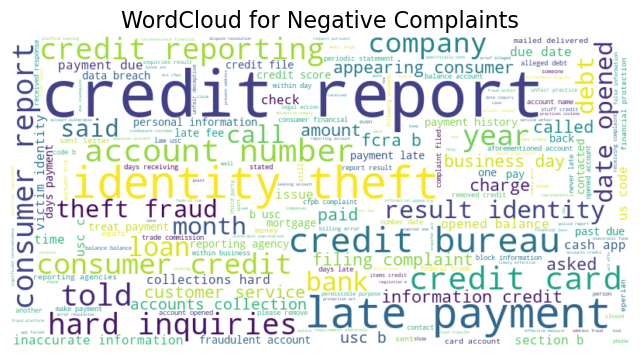

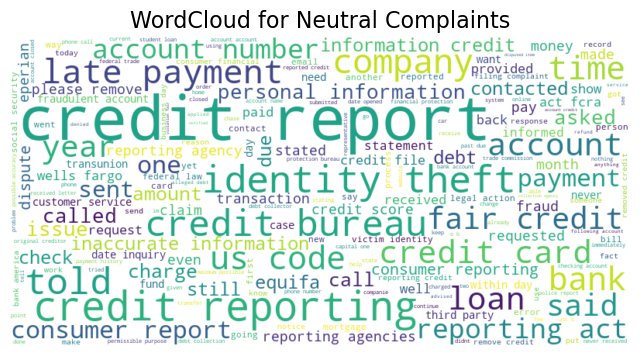

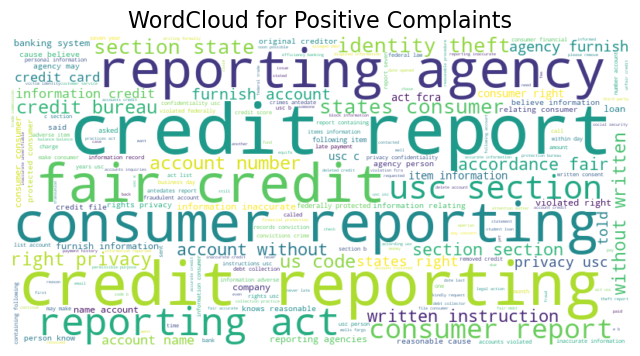

In [25]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Function to generate wordcloud
def plot_wordcloud(text, title):
    wc = WordCloud(width=800, height=400, background_color="white", colormap="viridis").generate(" ".join(text))
    plt.figure(figsize=(8,5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title, fontsize=16)
    plt.show()

# Wordcloud for Negative complaints
neg_text = df[df["sentiment_category"]=="Negative"]["clean_complaint"]
plot_wordcloud(neg_text, "WordCloud for Negative Complaints")

# Wordcloud for Neutral complaints
neu_text = df[df["sentiment_category"]=="Neutral"]["clean_complaint"]
plot_wordcloud(neu_text, "WordCloud for Neutral Complaints")

# Wordcloud for Positive complaints
pos_text = df[df["sentiment_category"]=="Positive"]["clean_complaint"]
plot_wordcloud(pos_text, "WordCloud for Positive Complaints")

# OPINION MINING

In [26]:
from textblob import TextBlob

# Add subjectivity (without recalculating polarity again if you already have it)
df["subjectivity"] = df["clean_complaint"].apply(lambda x: TextBlob(x).sentiment.subjectivity)

# Categorize subjectivity
def categorize_subjectivity(score):
    if score <= 0.3:
        return "Objective"
    elif score >= 0.7:
        return "Highly Opinionated"
    else:
        return "Moderately Opinionated"

df["opinion_category"] = df["subjectivity"].apply(categorize_subjectivity)

print(df[["complaint","sentiment","subjectivity","sentiment_category","opinion_category"]].head())


                                             complaint  sentiment  \
7    In XXXX, unauthorized transactions were made o...   0.142857   
67                          These are not my accounts.   0.000000   
130  Kindly address this issue on my credit report....   0.425000   
158  I want to stress that I did not give written p...   0.055000   
239  There are XXXX collections being reported to t...   0.093750   

     subjectivity sentiment_category        opinion_category  
7        0.225714           Positive               Objective  
67       0.000000            Neutral               Objective  
130      0.575000           Positive  Moderately Opinionated  
158      0.500000           Positive  Moderately Opinionated  
239      0.287500           Positive               Objective  


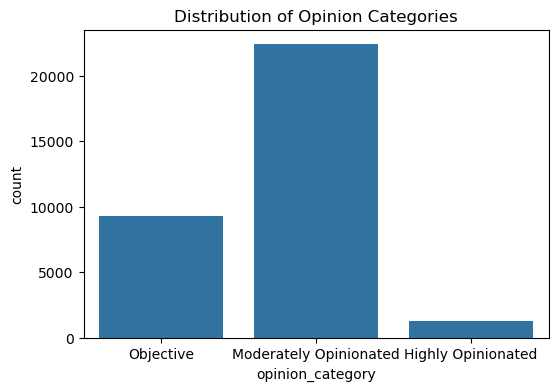

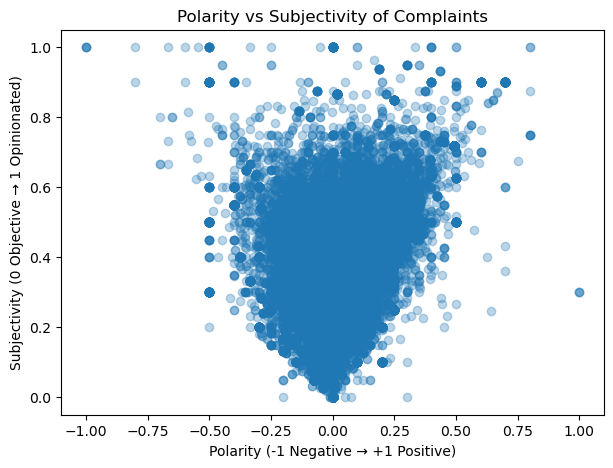

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Opinion Distribution
plt.figure(figsize=(6,4))
sns.countplot(x="opinion_category", data=df, order=["Objective","Moderately Opinionated","Highly Opinionated"])
plt.title("Distribution of Opinion Categories")
plt.show()

# Polarity vs Subjectivity Scatter Plot
plt.figure(figsize=(7,5))
plt.scatter(df["sentiment"], df["subjectivity"], alpha=0.3)
plt.title("Polarity vs Subjectivity of Complaints")
plt.xlabel("Polarity (-1 Negative → +1 Positive)")
plt.ylabel("Subjectivity (0 Objective → 1 Opinionated)")
plt.show()

#  MODULE 3 
#  FEATURE EXTRACTION

# BAG OF WORDS 

In [28]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize Bag of Words model (max 5000 features for efficiency)
bow_vectorizer = CountVectorizer(max_features=5000)

# Fit and transform the clean complaints
X_bow = bow_vectorizer.fit_transform(df["clean_complaint"])

print("BoW shape:", X_bow.shape)   # rows = docs, cols = words
print("Sample feature names:", bow_vectorizer.get_feature_names_out()[:30])


BoW shape: (32928, 5000)
Sample feature names: ['abide' 'abiding' 'ability' 'able' 'abovelisted' 'abovementioned'
 'abovereferenced' 'abruptly' 'absence' 'absent' 'absolute' 'absolutely'
 'absurd' 'abuse' 'abused' 'abusing' 'abusive' 'ac' 'acc' 'accept'
 'acceptable' 'acceptance' 'accepted' 'accepting' 'access' 'accessed'
 'accessible' 'accessing' 'accident' 'accidentally']


#  TF-IDF

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF model
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

# Fit and transform
X_tfidf = tfidf_vectorizer.fit_transform(df["clean_complaint"])

print("TF-IDF shape:", X_tfidf.shape)
print("Sample feature names:", tfidf_vectorizer.get_feature_names_out()[:30])


TF-IDF shape: (32928, 5000)
Sample feature names: ['abide' 'abiding' 'ability' 'able' 'abovelisted' 'abovementioned'
 'abovereferenced' 'abruptly' 'absence' 'absent' 'absolute' 'absolutely'
 'absurd' 'abuse' 'abused' 'abusing' 'abusive' 'ac' 'acc' 'accept'
 'acceptable' 'acceptance' 'accepted' 'accepting' 'access' 'accessed'
 'accessible' 'accessing' 'accident' 'accidentally']


#  N-GRAM 
#  BIGRAMS EXAMPLE

In [30]:
# Using bigrams (pairs of words)
bigram_vectorizer = CountVectorizer(max_features=5000, ngram_range=(2,2))

X_bigram = bigram_vectorizer.fit_transform(df["clean_complaint"])

print("Bigram BoW shape:", X_bigram.shape)
print("Sample bigrams:", bigram_vectorizer.get_feature_names_out()[:30])

Bigram BoW shape: (32928, 5000)
Sample bigrams: ['ability maimum' 'ability obtain' 'ability secure' 'able access'
 'able get' 'able make' 'able pay' 'able provide' 'absolutely verify'
 'abusing consumers' 'abusive company' 'acc properly' 'acceptable treat'
 'accepting unreliable' 'access account' 'access credit' 'access funds'
 'access information' 'accordance fair' 'accordance fcra'
 'accordance paragraph' 'accordance section' 'accordance sections'
 'accordance usc' 'accordance written' 'according fair' 'according fcra'
 'according law' 'according section' 'according us']


#  TOP WORDS VISUALISATION

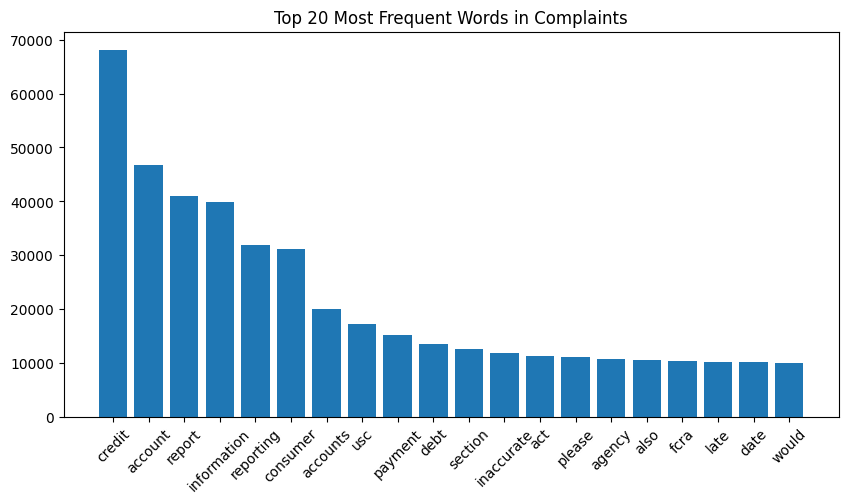

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# Sum of word frequencies
word_freq = np.asarray(X_bow.sum(axis=0)).flatten()
words = bow_vectorizer.get_feature_names_out()

# Sort top 20
top_indices = word_freq.argsort()[::-1][:20]
top_words = words[top_indices]
top_counts = word_freq[top_indices]

plt.figure(figsize=(10,5))
plt.bar(top_words, top_counts)
plt.title("Top 20 Most Frequent Words in Complaints")
plt.xticks(rotation=45)
plt.show()


In [33]:
import nltk

# Download both
nltk.download('punkt')
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt to C:\Users\Ananya
[nltk_data]     Goel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to C:\Users\Ananya
[nltk_data]     Goel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [34]:
tokenized_data = df["clean_complaint"].dropna().apply(nltk.word_tokenize)
print(tokenized_data.head())


7      [unauthorized, transactions, made, cash, app, ...
67                                            [accounts]
130    [kindly, address, issue, credit, report, asser...
158    [want, stress, give, written, permission, spec...
239    [collections, reported, consumer, agencies, lo...
Name: clean_complaint, dtype: object


In [ ]:
### WORD2VEC

In [2]:
!pip install matplotlib


   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ------------------ --------------------- 3.7/8.1 MB 19.9 MB/s eta 0:00:01
   ---------------------------------- ----- 7.1/8.1 MB 16.8 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 14.8 MB/s  0:00:00
   ---------------------------------------- 0.0/2.3 MB ? eta -:--:--
   ---------------------------------------- 2.3/2.3 MB 14.3 MB/s  0:00:00
   ---------------------------------------- 0.0/7.0 MB ? eta -:--:--
   --------------- ------------------------ 2.6/7.0 MB 13.7 MB/s eta 0:00:01
   ---------------------------- ----------- 5.0/7.0 MB 12.1 MB/s eta 0:00:01
   ---------------------------------------  6.8/7.0 MB 11.0 MB/s eta 0:00:01
   ---------------------------------------- 7.0/7.0 MB 10.5 MB/s  0:00:00

   ---------------------------------------- 0/7 [pyparsing]
   ---------------------------------------- 0/7 [pyparsing]
   ----- ---------------------------------- 1/7 [pillow]
   -----

[('creditonebk', 0.6629859209060669), ('jpmcb', 0.6573479175567627), ('credi', 0.6569233536720276), ('fraudulents', 0.6535465717315674), ('spotted', 0.6391760110855103)]


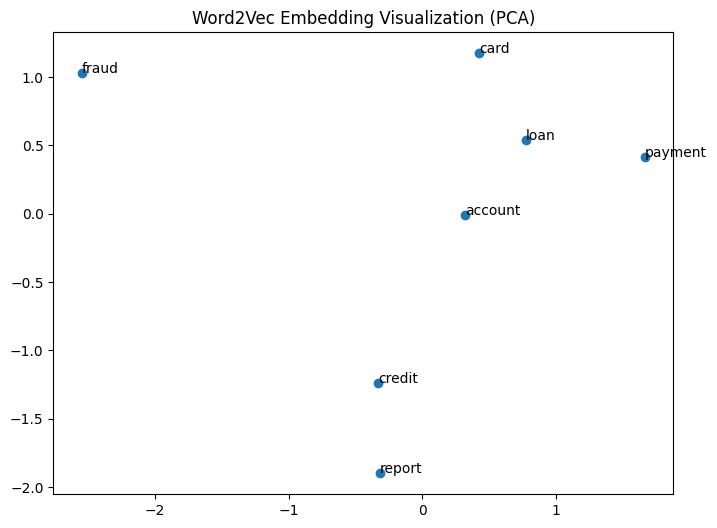

In [35]:
# Import libraries
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Train Word2Vec on your tokenized complaints
w2v_model = Word2Vec(
    sentences=tokenized_data,  # your tokenized complaints list
    vector_size=100,           # embedding dimensions
    window=5,                  # context window size
    min_count=2,               # ignore words with freq < 2
    workers=4,                 # use CPU cores
    sg=1                       # 1 = skip-gram, 0 = CBOW
)

# Save the model (optional)
w2v_model.save("word2vec_complaints.model")

# Check most similar words
print(w2v_model.wv.most_similar("credit", topn=5))

# ---- Visualization of word embeddings ----
# Select some common words to visualize
words = ["credit", "loan", "payment", "fraud", "account", "report", "card"]

# Get vectors for those words
word_vectors = [w2v_model.wv[w] for w in words if w in w2v_model.wv]
labels = [w for w in words if w in w2v_model.wv]

# Reduce dimensions to 2D with PCA
pca = PCA(n_components=2)
result = pca.fit_transform(word_vectors)

# Plot
plt.figure(figsize=(8,6))
plt.scatter(result[:, 0], result[:, 1])

for i, word in enumerate(labels):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]))

plt.title("Word2Vec Embedding Visualization (PCA)")
plt.show()


# GLOVE

In [36]:
import gensim.downloader as api

# Load pretrained GloVe (50 dimensions for speed)
glove_model = api.load("glove-wiki-gigaword-50")

# Check vector for a word
print(glove_model['credit'])

# Find most similar words
print(glove_model.most_similar('credit', topn=10))


[==================================================] 100.0% 66.0/66.0MB downloaded
[-0.14507   0.18523   0.87624  -0.40109  -0.54593   0.27876  -0.53844
 -0.073749  0.033542  0.29605  -0.015165  0.97952  -0.39951  -0.22479
  0.39135   0.18065  -0.099005 -0.56547   0.81349  -0.29484   1.1046
 -0.53413  -0.60684  -0.14538  -0.60555  -1.3484   -0.17349  -0.22012
 -0.10161   0.059905  3.1936    0.71105   1.2331    0.041516 -0.049376
 -0.075647 -0.66999  -0.63843   0.92575  -1.3003   -0.1455   -0.017748
  0.67626   0.21389  -0.53501  -0.91446   0.099732  1.0489    0.73924
  0.3247  ]
[('loans', 0.8646685481071472), ('debt', 0.8597277402877808), ('financial', 0.8573231101036072), ('banks', 0.8552632927894592), ('mortgage', 0.8468877673149109), ('interest', 0.8363410830497742), ('insurance', 0.8329691886901855), ('lending', 0.8282868266105652), ('payments', 0.817477285861969), ('savings', 0.8145905137062073)]


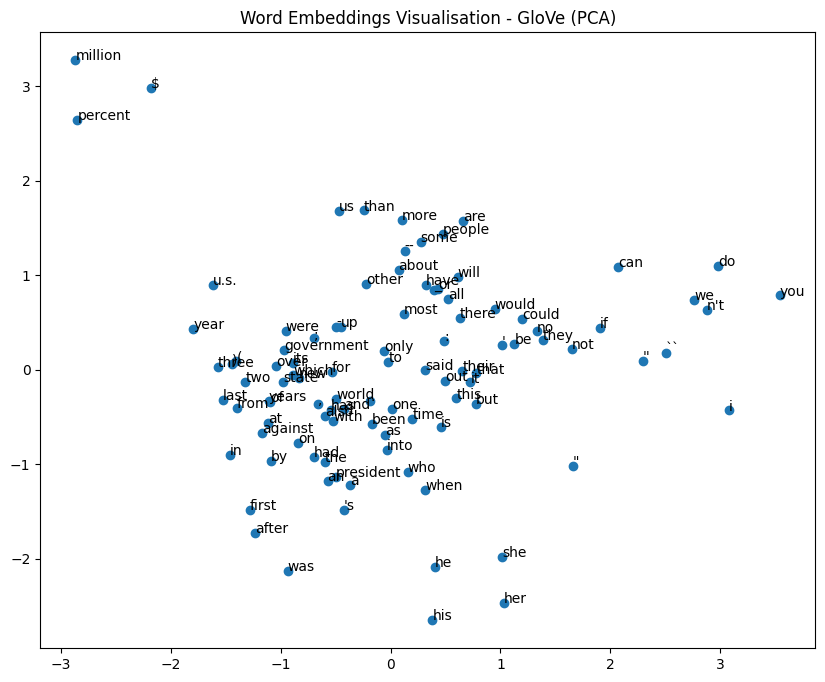

In [38]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Let's say glove_model is already loaded (keyed vectors)
words = list(glove_model.index_to_key)[:100]  # pick first 100 words
word_vectors = [glove_model[word] for word in words]

# Reduce dimensions to 2D
pca = PCA(n_components=2)
word_vecs_2d = pca.fit_transform(word_vectors)

# Plot
plt.figure(figsize=(10,8))
plt.scatter(word_vecs_2d[:,0], word_vecs_2d[:,1])

for i, word in enumerate(words):
    plt.annotate(word, (word_vecs_2d[i,0], word_vecs_2d[i,1]))

plt.title("Word Embeddings Visualisation - GloVe (PCA)")
plt.show()

#  Fastext

In [37]:
from gensim.models import FastText

# Train FastText
fasttext_model = FastText(sentences=tokenized_data, vector_size=100, window=5, min_count=5, workers=4)

# Word vector
print(fasttext_model.wv['credit'])

# Similar words
print(fasttext_model.wv.most_similar('credit', topn=10))


[ 1.0357364  -0.10343343 -1.4651138  -1.1102655   1.5475367   1.7077422
 -3.5450118  -0.909527   -2.9273887   3.7789283  -0.20749557  2.081518
  2.188942   -1.7120552  -1.4849037   0.01023018  0.3631847   2.0978386
  1.1660163  -0.20477949  1.7183155  -0.9252054  -2.2530038   0.59910935
  0.4608009   0.15865919 -2.3270376   0.15352495 -1.3632258  -0.819353
  0.19027436  1.66118     0.7051864  -0.10732623 -0.9341527  -1.5004157
 -2.0869412  -4.2310023   1.8181648  -2.4211926  -1.9845972   1.144589
 -1.5792148   3.0486078   0.15275536 -0.11471512 -0.11726018  1.3671136
 -0.9842658  -0.27634984 -0.7940546   0.3486033  -1.4831609  -3.3904219
  2.147234   -0.6657491   3.6824412   0.07864366 -0.5622653   2.0620034
  0.8302519   0.05883418  1.4193779  -1.1461484  -0.09589329  0.3243401
  3.2727249   2.0835464  -1.8429188  -2.2083085   1.1217076  -0.31571555
 -0.13216844 -0.924767    0.0555528   0.15659635  1.574129   -0.8563985
  0.6292472   0.09139767 -3.7122338   1.4969699   1.4537083  -0.4

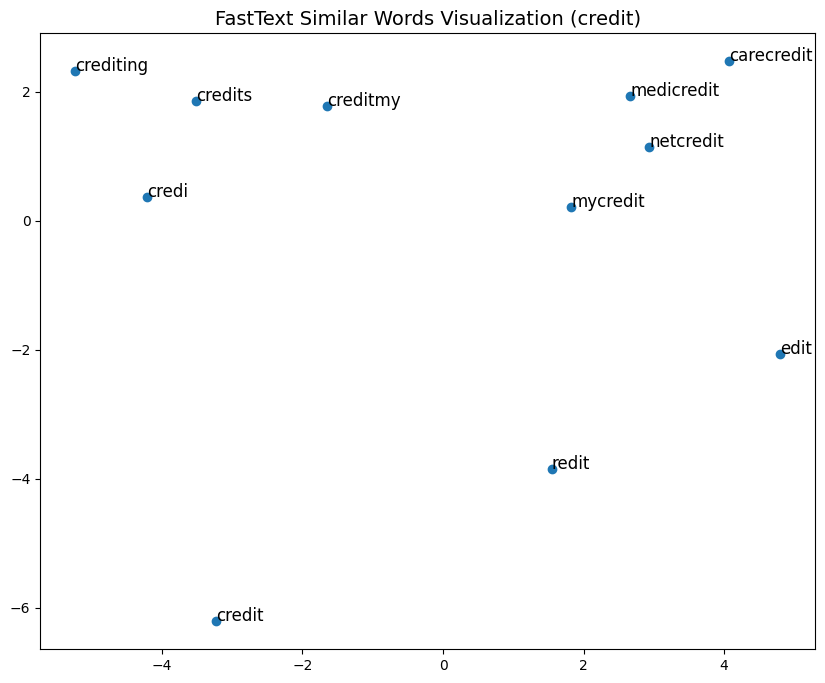

In [42]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Get top 10 most similar words to "credit"
similar_words = fasttext_model.wv.most_similar('credit', topn=10)

# Include "credit" + similar words
words = ['credit'] + [w for w, _ in similar_words]
vectors = [fasttext_model.wv[w] for w in words]

# Reduce to 2D using PCA
pca = PCA(n_components=2)
result = pca.fit_transform(vectors)

# Plot
plt.figure(figsize=(10, 8))
plt.scatter(result[:, 0], result[:, 1], marker='o')

for i, word in enumerate(words):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]), fontsize=12)

plt.title("FastText Similar Words Visualization (credit)", fontsize=14)
plt.show()

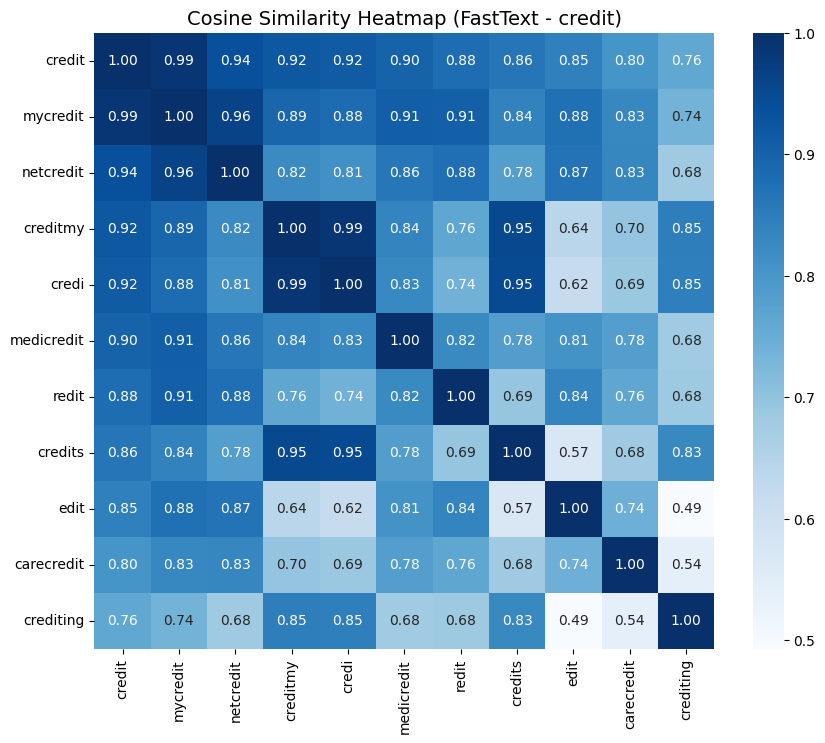

In [43]:
import numpy as np
import seaborn as sns

# Words to include
words = ['credit'] + [w for w, _ in similar_words]

# Create similarity matrix
similarity_matrix = np.zeros((len(words), len(words)))

for i, w1 in enumerate(words):
    for j, w2 in enumerate(words):
        similarity_matrix[i][j] = fasttext_model.wv.similarity(w1, w2)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, xticklabels=words, yticklabels=words, annot=True, fmt=".2f", cmap="Blues")
plt.title("Cosine Similarity Heatmap (FastText - credit)", fontsize=14)
plt.show()

#  MODULE 4 - LDA AND NMF

In [45]:
!pip install pyLDAvis

   ---------------------------------------- 0.0/2.6 MB ? eta -:--:--
   -------------------- ------------------- 1.3/2.6 MB 6.7 MB/s eta 0:00:01
   ------------------------------------ --- 2.4/2.6 MB 6.4 MB/s eta 0:00:01
   ---------------------------------------- 2.6/2.6 MB 5.7 MB/s  0:00:00

   ---------------------------------------- 0/3 [funcy]
   ------------- -------------------------- 1/3 [numexpr]
   -------------------------- ------------- 2/3 [pyLDAvis]
   -------------------------- ------------- 2/3 [pyLDAvis]
   -------------------------- ------------- 2/3 [pyLDAvis]
   -------------------------- ------------- 2/3 [pyLDAvis]
   -------------------------- ------------- 2/3 [pyLDAvis]
   -------------------------- ------------- 2/3 [pyLDAvis]
   -------------------------- ------------- 2/3 [pyLDAvis]
   -------------------------- ------------- 2/3 [pyLDAvis]
   -------------------------- ------------- 2/3 [pyLDAvis]
   -------------------------- ------------- 2/3 [pyLDAvis]
 

In [48]:
import gensim
from gensim import corpora
from gensim.models import LdaModel

# Example tokenized data (replace with your tokenized complaints)
tokenized_data = [
    ["unauthorized", "transactions", "cash", "app"],
    ["accounts"],
    ["credit", "report", "asserted"],
    ["collections", "reported", "agencies"]
]

# Create dictionary and corpus for LDA
dictionary = corpora.Dictionary(tokenized_data)
corpus = [dictionary.doc2bow(text) for text in tokenized_data]

# Train LDA model
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=3, random_state=42, passes=10)

# Print the discovered topics
topics = lda_model.print_topics(num_words=5)
for idx, topic in topics:
    print(f"Topic {idx}: {topic}")


Topic 0: 0.174*"asserted" + 0.174*"report" + 0.174*"credit" + 0.173*"accounts" + 0.044*"agencies"
Topic 1: 0.174*"cash" + 0.174*"app" + 0.174*"transactions" + 0.174*"unauthorized" + 0.044*"accounts"
Topic 2: 0.200*"agencies" + 0.200*"reported" + 0.200*"collections" + 0.051*"accounts" + 0.050*"report"


In [49]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

docs = [
    "Unauthorized transactions made on my cash app account",
    "Incorrect accounts details in report",
    "Kindly address issue in credit report",
    "Collections reported wrongly by agencies"
]

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
tfidf = tfidf_vectorizer.fit_transform(docs)

# NMF model
nmf = NMF(n_components=2, random_state=42)
nmf_topics = nmf.fit_transform(tfidf)

# Print top words for each topic
feature_names = tfidf_vectorizer.get_feature_names_out()
for idx, topic in enumerate(nmf.components_):
    print(f"Topic {idx}:")
    print([feature_names[i] for i in topic.argsort()[-5:]])


Topic 0:
['address', 'incorrect', 'accounts', 'details', 'report']
Topic 1:
['unauthorized', 'collections', 'reported', 'agencies', 'wrongly']


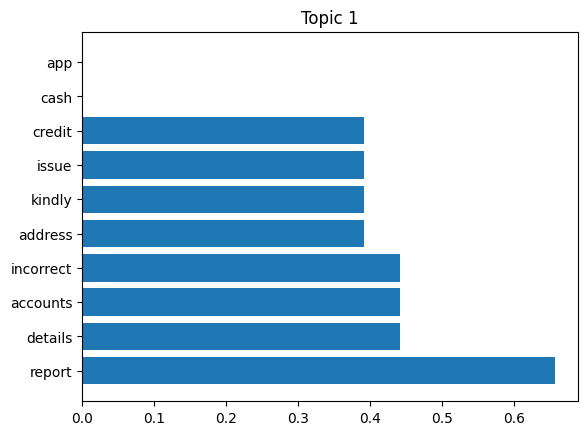

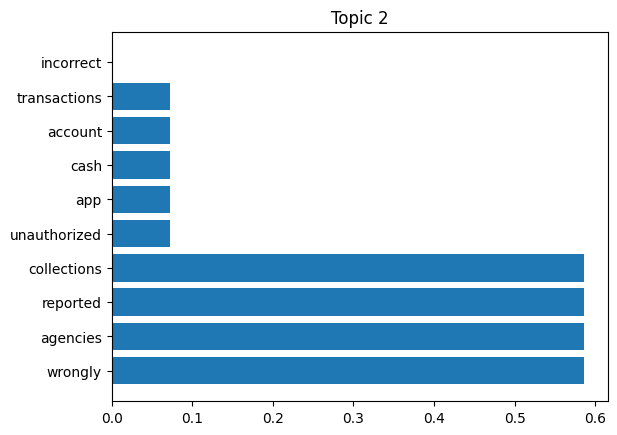

In [51]:
import matplotlib.pyplot as plt

def plot_top_words(model, feature_names, n_top_words, title):
    for topic_idx, topic in enumerate(model.components_):
        plt.figure()
        plt.barh([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]], 
                 topic[topic.argsort()[:-n_top_words - 1:-1]])
        plt.title(f"Topic {topic_idx+1}")
        plt.show()

plot_top_words(nmf, feature_names, 10, "Topics in NMF model")


#  MODULE 5 
#  TEXT CLASSIFICATION - ML MODEL

✅ Classification Report:
              precision    recall  f1-score   support

     Account       0.00      0.00      0.00       0.0
     Banking       0.00      0.00      0.00       1.0
 Credit Card       0.00      0.00      0.00       0.0
        Loan       0.00      0.00      0.00       1.0

    accuracy                           0.00       2.0
   macro avg       0.00      0.00      0.00       2.0
weighted avg       0.00      0.00      0.00       2.0



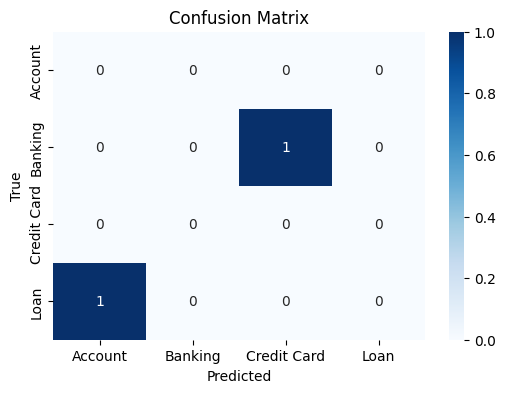

In [56]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------
# Example dataset (replace with your real dataset)
# ---------------------------
data = pd.DataFrame({
    "complaint": [
        "Unauthorized transactions on my credit card",
        "My loan application was rejected unfairly",
        "Wrong account details in my report",
        "Collections reported wrongly by agencies",
        "Issues with online banking transactions"
    ],
    "category": ["Credit Card", "Loan", "Account", "Collections", "Banking"]
})

# ---------------------------
# Step 1: Train-test split (no stratify since each class has only 1 sample)
# ---------------------------
X_train, X_test, y_train, y_test = train_test_split(
    data["complaint"],
    data["category"],
    test_size=0.4,
    random_state=42
)

# ---------------------------
# Step 2: Vectorization (TF-IDF)
# ---------------------------
vectorizer = TfidfVectorizer(stop_words="english", max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# ---------------------------
# Step 3: Train classifier
# ---------------------------
model = LogisticRegression(max_iter=1000)
model.fit(X_train_tfidf, y_train)

# ---------------------------
# Step 4: Predictions & Evaluation
# ---------------------------
y_pred = model.predict(X_test_tfidf)

print("✅ Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

# ---------------------------
# Step 5: Confusion Matrix
# ---------------------------
labels = sorted(set(y_test) | set(y_pred))  # safe union of labels
cm = confusion_matrix(y_test, y_pred, labels=labels)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


#  QUICK IMPORTS AMD CHECKS

In [32]:
# 0) Imports and quick checks
import numpy as np
import pandas as pd

# sklearn imports
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder, label_binarize

# classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier

import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# If you plan SMOTE (optional)
# pip install imbalanced-learn
from imblearn.over_sampling import RandomOverSampler, SMOTE

# quick check - ensure columns exist
print("Columns:", df.columns.tolist())
assert "clean_complaint" in df.columns, "clean_complaint column missing"
assert "Product" in df.columns, "Product (label) column missing"

Columns: ['Date received', 'Product', 'Sub-product', 'Issue', 'Sub-issue', 'complaint', 'Company public response', 'Company', 'State', 'ZIP code', 'Tags', 'Consumer consent provided?', 'Submitted via', 'Date sent to company', 'Company response to consumer', 'Timely response?', 'Consumer disputed?', 'Complaint ID', 'clean_complaint', 'sentiment', 'subjectivity', 'opinion_category', 'sentiment_category']


# FEATURE PREPARATION

In [34]:
# === Step 1: Prepare features and labels ===
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

# Assuming your cleaned text column is 'clean_complaint' and target is 'sentiment_category'
texts = df['clean_complaint'].astype(str)  # input text
labels = df['sentiment_category']          # target classes: 'Positive', 'Neutral', 'Negative'

# Encode labels to numbers
le = LabelEncoder()
y = le.fit_transform(labels)

# Convert text to TF-IDF features
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))  # you can tweak max_features
X = tfidf.fit_transform(texts)

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Shape of training set:", X_train.shape)
print("Shape of testing set:", X_test.shape)
print("Sample classes:", le.classes_)

Shape of training set: (26342, 5000)
Shape of testing set: (6586, 5000)
Sample classes: ['Negative' 'Neutral' 'Positive']


# TRAINING MULTIPLE CLASSIFIERS


Training LogisticRegression ...
LogisticRegression done. accuracy=0.7820  f1_macro=0.7796

Training MultinomialNB ...
MultinomialNB done. accuracy=0.6230  f1_macro=0.6185

Training RandomForest ...
RandomForest done. accuracy=0.7891  f1_macro=0.7840

Training LinearSVC ...
LinearSVC done. accuracy=0.7973  f1_macro=0.7914

Model comparison:


,model,accuracy,precision_macro,recall_macro,f1_macro,cv_f1_macro
0,LinearSVC,0.797297,0.791050,0.791879,0.791420,0.778034
1,RandomForest,0.789098,0.793189,0.778654,0.784011,0.778014
2,LogisticRegression,0.781962,0.781752,0.779243,0.779551,0.762908
3,MultinomialNB,0.622988,0.712902,0.615089,0.618483,0.609114


Saved results to model_comparison_results.csv


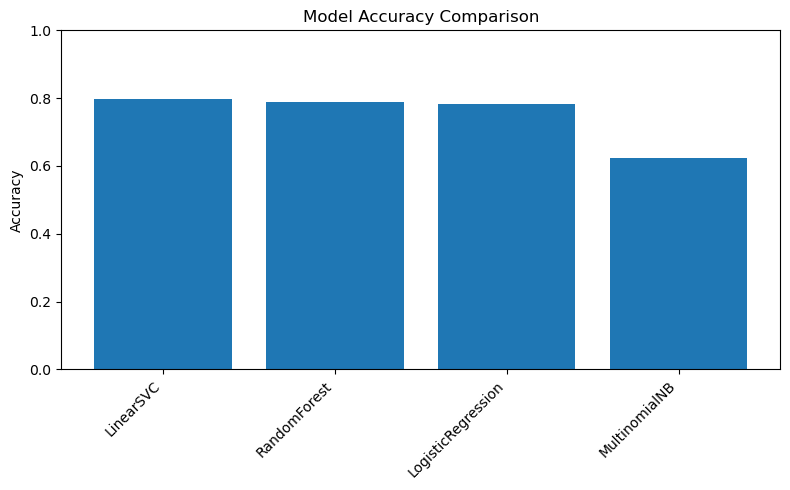

Best model by F1-macro: LinearSVC


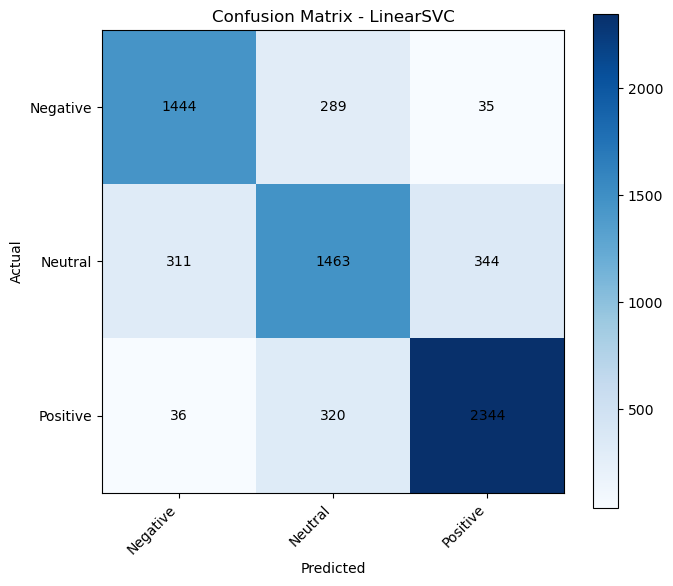


Classification report for best model:
              precision    recall  f1-score   support

    Negative       0.81      0.82      0.81      1768
     Neutral       0.71      0.69      0.70      2118
    Positive       0.86      0.87      0.86      2700

    accuracy                           0.80      6586
   macro avg       0.79      0.79      0.79      6586
weighted avg       0.80      0.80      0.80      6586

Saved best model to best_model.joblib


In [35]:
# === Train multiple classifiers, evaluate, table + visualizations ===

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt

# =============================
# 1. Define models
# =============================
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42),
    "MultinomialNB": MultinomialNB(),
    "RandomForest": RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42),
    "LinearSVC": LinearSVC(class_weight="balanced", max_iter=10000, random_state=42)
}

results = []

# =============================
# 2. Train and evaluate models
# =============================
for name, model in models.items():
    print(f"\nTraining {name} ...")
    model.fit(X_train, y_train)
    
    # predictions
    y_pred = model.predict(X_test)
    
    # scores
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average="macro", zero_division=0)
    rec = recall_score(y_test, y_pred, average="macro", zero_division=0)
    f1 = f1_score(y_test, y_pred, average="macro", zero_division=0)
    
    # 3-fold CV f1_macro
    try:
        cv_scores = cross_val_score(model, X_train, y_train, cv=3, scoring="f1_macro", n_jobs=-1)
        cv_mean = np.mean(cv_scores)
    except Exception:
        cv_mean = np.nan
    
    # store results
    results.append({
        "model": name,
        "accuracy": acc,
        "precision_macro": prec,
        "recall_macro": rec,
        "f1_macro": f1,
        "cv_f1_macro": cv_mean
    })
    
    # save each trained model
    joblib.dump(model, f"{name}_model.joblib")
    print(f"{name} done. accuracy={acc:.4f}  f1_macro={f1:.4f}")

# =============================
# 3. Model comparison table
# =============================
res_df = pd.DataFrame(results).sort_values("f1_macro", ascending=False).reset_index(drop=True)
print("\nModel comparison:")
display(res_df)

# Save results
res_df.to_csv("model_comparison_results.csv", index=False)
print("Saved results to model_comparison_results.csv")

# =============================
# 4. Accuracy bar chart
# =============================
plt.figure(figsize=(8,5))
x = np.arange(len(res_df["model"]))
heights = res_df["accuracy"].values
plt.bar(x, heights)
plt.xticks(x, res_df["model"], rotation=45, ha="right")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.title("Model Accuracy Comparison")
plt.tight_layout()
plt.show()

# =============================
# 5. Confusion matrix of best model
# =============================
best_model_name = res_df.loc[0, "model"]
print("Best model by F1-macro:", best_model_name)

# load model (already saved earlier)
best_model = joblib.load(f"{best_model_name}_model.joblib")

y_pred_best = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(7,6))
plt.imshow(cm, interpolation='nearest', cmap="Blues")
plt.title(f"Confusion Matrix - {best_model_name}")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.colorbar()

# annotate cells
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 verticalalignment="center")

# safe tick labels (use le if exists, else fallback to unique labels)
try:
    tick_labels = le.classes_
except NameError:
    tick_labels = np.unique(y_test)

plt.xticks(np.arange(len(tick_labels)), tick_labels, rotation=45, ha="right")
plt.yticks(np.arange(len(tick_labels)), tick_labels)
plt.tight_layout()
plt.show()

# =============================
# 6. Classification report
# =============================
print("\nClassification report for best model:")
try:
    print(classification_report(y_test, y_pred_best, target_names=le.classes_, zero_division=0))
except NameError:
    print(classification_report(y_test, y_pred_best, zero_division=0))

# Save best model
joblib.dump(best_model, "best_model.joblib")
print("Saved best model to best_model.joblib")

# =============================
# 7. Top features for Logistic Regression (optional)
# =============================
if best_model_name == "LogisticRegression":
    try:
        vec = tfidf  # assuming tfidf vectorizer still in scope
        coef = best_model.coef_
        feature_names = vec.get_feature_names_out()
        for i, cls in enumerate(tick_labels):
            top_pos = np.argsort(coef[i])[-15:]
            top_neg = np.argsort(coef[i])[:15]
            print(f"\nTop positive features for class {cls}:")
            print(feature_names[top_pos])
            print(f"Top negative features for class {cls}:")
            print(feature_names[top_neg])
    except Exception as e:
        print("Could not extract top features automatically:", e)

In [42]:
pipeline = joblib.load("final_sentiment_pipeline.joblib")

new_complaints = [
    "I am very unhappy with the credit card charges on my account.",
    "The bank resolved my loan issue quickly, very satisfied!",
    "My mobile banking app keeps crashing."
]

predictions = pipeline.predict(new_complaints)
decoded_preds = le.inverse_transform(predictions)

print("\nPredictions for new complaints:")
for complaint, pred in zip(new_complaints, decoded_preds):
    print(f"Complaint: {complaint}\n → Predicted Sentiment: {pred}\n")



Predictions for new complaints:
Complaint: I am very unhappy with the credit card charges on my account.
 → Predicted Sentiment: Positive

Complaint: The bank resolved my loan issue quickly, very satisfied!
 → Predicted Sentiment: Positive

Complaint: My mobile banking app keeps crashing.
 → Predicted Sentiment: Neutral



# USING BEST MODEL ON PREDICTION OF NEW TEXT

# VECTORISER 

In [38]:
from sklearn.pipeline import Pipeline

# Create pipeline with TF-IDF and best model
pipeline = Pipeline([
    ("tfidf", tfidf), 
    ("classifier", best_model)
])

# Save pipeline
joblib.dump(pipeline, "final_sentiment_pipeline.joblib")
print("Saved pipeline to final_sentiment_pipeline.joblib")

Saved pipeline to final_sentiment_pipeline.joblib


# LOADING PIPELINE

In [39]:
# Load pipeline
pipeline = joblib.load("final_sentiment_pipeline.joblib")

# Directly predict (pipeline handles TF-IDF + model automatically)
test_texts = ["The service was amazing!", "This bank is terrible."]
print(pipeline.predict(test_texts))

[1 1]
